## Online Retail Dataset

By Bhargav Nallani Chakravarthula

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Feature Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
Description: Product (item) name. Nominal. 
Quantity: The quantities of each product (item) per transaction. Numeric.	
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 
UnitPrice: Unit price. Numeric, Product price per unit in sterling. 
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
Country: Country name. Nominal, the name of the country where each customer resides.



## Exploratory Data Analysis

In [3]:
print("Shape of the data is ", df.shape)

Shape of the data is  (541909, 8)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


We can observed that Customer ID has null values (i.e only 406829 records are avilable). Desription also has missing values.

In [5]:
print("Number of unique Customers", df['CustomerID'].nunique())
print("Number of unique products", df['StockCode'].nunique())
print("Number of unique transactions", df['InvoiceNo'].nunique())
print("Number of unique countries", df['Country'].nunique())

print("Percentage of null values", round((df['CustomerID'].isnull().sum()*100)/len(df),3 ), "%")


Number of unique Customers 4372
Number of unique products 4070
Number of unique transactions 25900
Number of unique countries 38
Percentage of null values 24.927 %


Checking the number of cancelled orders

In [6]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]

In [7]:
cancelled_orders.min()

InvoiceNo                             C536379
Description     50'S CHRISTMAS GIFT BAG LARGE
Quantity                               -80995
InvoiceDate               2010-12-01 09:41:00
UnitPrice                                0.01
CustomerID                              12346
Country                             Australia
dtype: object

In [8]:
print("Number of cancelled orders :", len(cancelled_orders))
print("Percentage of cancelled orders :", len(cancelled_orders)*100/(df['InvoiceNo']).nunique(), "%")

Number of cancelled orders : 9288
Percentage of cancelled orders : 35.86100386100386 %


Analyzing the items per order 

In [9]:
itemsFrequency = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
itemsFrequency.columns = ['productsNumber']
itemsFrequency.head()

,productsNumber
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [10]:
itemsFrequency.describe()

,productsNumber
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


Analyzing avaerage orders per customer

In [11]:
customerOrders = pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].nunique())
customerOrders.head()

,InvoiceNo
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [12]:
customerOrders.describe()

,InvoiceNo
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


The average products purchased by a customer is 5

Now that we have analyzed the cancelled orders, products per transactions, transactions made by customer. We will go ahead with a clustering mechanism called RFM (Recency, Frequency and Monetory) analysis which leverages the past customer behaviour and segregates them into clusters. This custer can then be used to better understand the service penetration into respective markets. 

## Data Preprocessing

In [13]:
#Considering UK based purchases only

df_UK = df[df['Country'] == 'United Kingdom' ] 

#removing cancelled orders

df_UK = df_UK[df_UK['Quantity'] > 0]

#removing customer ID = NA

df_UK.dropna(subset = ['CustomerID'],how='all',inplace=True)

#restrict the data to one full year because it's better to use a metric per Months or Years in RFM

df_UK = df_UK[df_UK['InvoiceDate']>= "2010-12-09"]

#exploring the unique values of each attribute
print("Number of transactions: ", df_UK['InvoiceNo'].nunique())
print("Number of products purchased: ",df_UK['StockCode'].nunique())
print("Number of customers:", df_UK['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(df_UK['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Number of transactions:  16017
Number of products purchased:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


## RFM analysis

RFM stands for Recency, Frequency and Monitory

Recency : Number of days since the last purchase
Frequency : Total number of purchases
Monitory : Customer spendings

source : https://www.putler.com/rfm-analysis/

Recency

In [14]:
df_UK['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [15]:
#We will use the last purchase date as reference to calculate the recency

In [16]:
import time, warnings
import datetime as dt
recentDate = dt.date(2011,12,9)
print(recentDate)

2011-12-09


In [17]:
#creating a feature called date, which contains the date of purchase only and adding it to df

df_UK['date'] = df_UK['InvoiceDate'].dt.date
df_UK['date'].head()

19632    2010-12-09
19633    2010-12-09
19634    2010-12-09
19635    2010-12-09
19636    2010-12-09
Name: date, dtype: object

In [18]:
#Groupby customers to check the last purchase date

recency = df_UK.groupby(by = 'CustomerID', as_index = False)['date'].max()
recency.columns = ['CustomerID', 'LatestPurchase'] 
recency.head()

,CustomerID,LatestPurchase
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [19]:
recency['Recency'] = recency['LatestPurchase'].apply(lambda x: (recentDate - x).days)
recency = recency.drop('LatestPurchase', axis = 1)
recency.head()


,CustomerID,Recency
0,12346.0,325
1,12747.0,2
2,12748.0,0
3,12749.0,3
4,12820.0,3


Frequency

Frequency is calculating how many times customer purchased form the store. To calculate that we need to compute the number of invoices generated for that customer.

In [20]:
# drop duplicates
df_UK_frequency = df_UK
df_UK_frequency.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency = df_UK_frequency.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


Monetary

Monetary is the amount of money customer spent.

In [21]:
#Adding a new feature total cost

df_UK['TotalCost'] = df_UK['Quantity'] * df_UK['UnitPrice']
monetary = df_UK.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


## Creating RFM table

In [22]:
RFM_df = recency.merge(frequency, on= 'CustomerID')
RFM_df = RFM_df.merge(monetary, on = 'CustomerID')

In [23]:
RFM_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12747.0,2,10,658.89
2,12748.0,0,196,3739.23
3,12749.0,3,5,98.35
4,12820.0,3,4,58.20


In [24]:
RFM_df.set_index('CustomerID', inplace = True)
RFM_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


## MODEL Fitting

In [25]:
RFM_df.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.279236,-0.027727
Frequency,-0.279236,1.000000,0.156431
Monetary,-0.027727,0.156431,1.000000


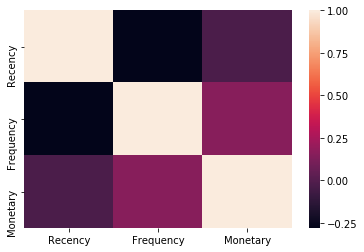

In [26]:
import seaborn as sns

sns.heatmap(RFM_df.corr())
plt.show()

 Data Normalization

In [27]:
#log transformation
RFM_M = np.log(RFM_df['Monetary']+0.1)
RFM_R = np.log(RFM_df['Recency']+0.1) #can't take log(0) and so add a small number
RFM_F = np.log(RFM_df['Frequency'])

RFM_log = pd.DataFrame({'Monetary': RFM_M,'Recency': RFM_R,'Frequency': RFM_F})
RFM_log.head()

,Frequency,Monetary,Recency
CustomerID,,,
12346.0,0.000000,11.253944,5.784133
12747.0,2.302585,6.490708,0.741937
12748.0,5.278115,8.226662,-2.302585
12749.0,1.609438,4.589549,1.131402
12820.0,1.386294,4.065602,1.131402


In [28]:
RFM_log.corr()

,Frequency,Monetary,Recency
Frequency,1.000000,0.715609,-0.569951
Monetary,0.715609,1.000000,-0.364351
Recency,-0.569951,-0.364351,1.000000


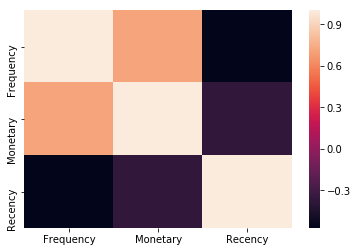

In [29]:
sns.heatmap(RFM_log.corr())
plt.show()

K-Means Culstering Model

In K-means clustering its a challenge to figure out the optimum number of clusters to be used. We will experiment with different number of clusters and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). In layman terms, the cluster with highest silhouette coefficient is the winner. 

In [30]:
import sklearn.cluster as cluster
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score

RFM_matrix = RFM_log.as_matrix()

for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(RFM_matrix)
    clusters = kmeans.predict(RFM_matrix)
    silhouette_avg = silhouette_score(RFM_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.389366519641
For n_clusters = 3 The average silhouette_score is : 0.305500221407
For n_clusters = 4 The average silhouette_score is : 0.309758245702
For n_clusters = 5 The average silhouette_score is : 0.289832184172
For n_clusters = 6 The average silhouette_score is : 0.295353516886
For n_clusters = 7 The average silhouette_score is : 0.29123464509
For n_clusters = 8 The average silhouette_score is : 0.291348098212
For n_clusters = 9 The average silhouette_score is : 0.294314097872


Evidently n_clusters = 2 has the highest score.

In [31]:
kmeans = KMeans(init='k-means++', n_clusters = 2, n_init=100)
kmeans.fit(RFM_matrix)
clusters_customers = kmeans.predict(RFM_matrix)
silhouette_avg = silhouette_score(RFM_matrix, clusters_customers)
print('silhouette_score: {:<.3f}'.format(silhouette_avg))

silhouette_score: 0.389


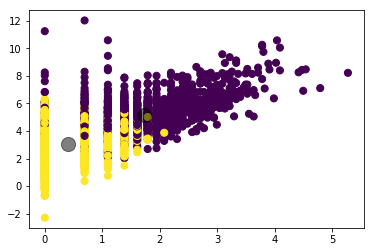

In [32]:
#create a scatter plot
plt.scatter(RFM_matrix[:, 0], RFM_matrix[:, 1], c=clusters_customers, s=50, cmap='viridis')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

Unfortunately we didnt obtain proper seperate clusters. 

Limitations of k-means clustering:

There is no assurance that it will lead to the global best solution.
Can't deal with different shapes(not circular) and consider one point's probability of belonging to more than one cluster.